**SNM FOR LABELLED TEXT DATA**

**IMPORT LIBRARIES**

In [99]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from wordcloud import WordCloud, STOPWORDS

**ABOUT THE DATA**

The text data is identical to the one used in Naive Bayes. The label text data is derived from the Twitter APIs for #FBI and #USACRIME. The hashtags #USACRIME and #CRIMEUSA are used interchangeably on Twitter to collect data about the use of hostages, as both serve the same purpose. 


In [100]:
# READ THE DATA
crimeusa_data = pd.read_csv('R_CRIMEUSA_API.csv')
usacrime_data = pd.read_csv('R_USACRIME_API.csv')
cleaned_tweet_data = pd.read_csv('cleaned_twitter_crimeusa_data_py.csv')
fbi_data = pd.read_csv('R_FBI_API.csv')
tweet_fbi_data = pd.read_csv('cleaned_twitter_fbi_data_py.csv')


**DATA CLEANING**

FBI and USA CRIME datasets are combined into one. To assess #crime, the data is purified by deleting all other columns from the dataset, leaving only the text column. Throughout this cleaning operation, Tokenization from the NLTK library and Countvectorizer from the scikit-learn library are both employed.

The text lemmatization is used for the subsequent step after the data has been cleaned. The technique of collecting together the various inflected forms of a word so that they can be studied as a single item is known as lemmatization. Lemmatization is similar to stemming in that it adds context to words. As a result, it connects words with similar meanings to a single word.

In [101]:
#MERGE CRIME USA ANDD USA CRIME DATAFRAMES
tweet_data_crimeusa = pd.concat([crimeusa_data, usacrime_data], axis=0)
tweet_data_crimeusa.head()

#ADD A COLUMN TO THE DATAFRAME
tweet_data_crimeusa['label'] = 'USA CRIME'
fbi_data['label'] = 'FBI'

#REMOVE RETWEETS
tweet_data_crimusa = tweet_data_crimeusa[~tweet_data_crimeusa['text'].str.contains('RT')]
fbi_data = fbi_data[~fbi_data['text'].str.contains('RT')]

#MERGE CLEAN TEXT COLUMN FROM CLEANED TWEET DATA WITH THE TWEET DATA
tweet_data_crimeusa = pd.merge(tweet_data_crimeusa, cleaned_tweet_data, on='text', how='left')
fbi_data = pd.merge(fbi_data, tweet_fbi_data, on='text', how='left')

#DROP THE COLUMNS THAT ARE NOT NEEDED
tweet_data_crimeusa = tweet_data_crimeusa.drop(['Unnamed: 0_x','Unnamed: 0_y','text','Tweet_tokenized','Tweet_without_stop','Tweet_stemmed'], axis=1)
fbi_data = fbi_data.drop(['Unnamed: 0_x','Unnamed: 0_y','text','Tweet_tokenized','Tweet_without_stop','Tweet_stemmed'], axis=1)

#REARRANGE THE COLUMNS
tweet_data_crimeusa.insert(0, 'label', tweet_data_crimeusa.pop('label'))
tweet_data_crimeusa.insert(1, 'clean text', tweet_data_crimeusa.pop('clean text'))
fbi_data.insert(0, 'label', fbi_data.pop('label'))
fbi_data.insert(1, 'clean text', fbi_data.pop('clean text'))

#RENAME THE CLEAN TEXT COLUMN
tweet_data_crimeusa = tweet_data_crimeusa.rename(columns={'clean text':'text'})
fbi_data = fbi_data.rename(columns={'clean text':'text'})

#MERGE FBI AND USA CRIME DATASETS
tweet_data = pd.concat([tweet_data_crimeusa, fbi_data], axis=0)

#REMOVE THE COLUMNS THAT ARE NOT NEEDED BEFORE EXPORTING THE DATA
#tweet_data = tweet_data.drop(['Tweet_lemmatized'], axis=1)

# HEAD OF THE DATA
tweet_data.head()

,label,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,Tweet_lemmatized
0,USA CRIME,Onlyrockradio Donate tiorr internet radio supp...,False,1,Only_rock_radio,2022-10-10 21:56:24,True,1.579587e+18,1579591706663878656,4.913321e+09,"<a href=""https://mobile.twitter.com"" rel=""nofo...",SceneCleaners,0,False,False,NaN,NaN,"['onlyrockradio', 'donate', 'tiorr', 'internet..."
1,USA CRIME,Enjoy exciting accounts of realism from the pe...,False,0,NaN,2022-10-10 21:09:40,True,NaN,1579579945655087104,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",LaydenRobinson,0,False,False,NaN,NaN,"['enjoy', 'exciting', 'account', 'realism', 'p..."
2,USA CRIME,Metaverse Opinion amp Politics USA Trending Cr...,False,0,NaN,2022-10-10 20:21:00,True,NaN,1579567695825190917,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",MetaversePosts,0,False,False,NaN,NaN,"['metaverse', 'opinion', 'amp', 'politics', 'u..."
3,USA CRIME,Someone in Alabama ought to seriously question...,False,0,NaN,2022-10-10 18:56:52,True,NaN,1579546522144112642,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",AlwaysVoteTruth,0,False,False,NaN,NaN,"['someone', 'alabama', 'ought', 'seriously', '..."
4,USA CRIME,DeanPreston instead whining about USA blueange...,False,0,DeanPreston,2022-10-10 15:46:33,True,NaN,1579498631153221634,5.924374e+07,"<a href=""http://twitter.com/download/iphone"" r...",JohnnyU31776738,0,False,False,NaN,NaN,"['deanpreston', 'instead', 'whining', 'usa', '..."


Text(0, 0.5, 'Frequency')

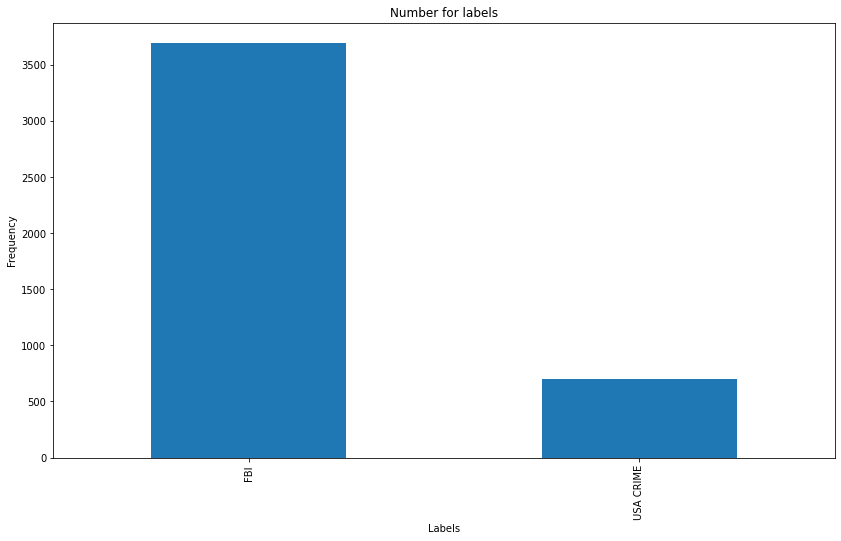

In [102]:
#TEXT LEMMATIZED COLUMN
df =tweet_data[['label','Tweet_lemmatized']]

#REMOVE PUNCTUATION FROM TEXT LEMMATIZED COLUMN
final_tweets=[str(i).replace(",","").replace("[","").replace("]","").replace("'","") for i in df['Tweet_lemmatized']]

#ADD THE FINAL TWEETS TO THE DATAFRAME
df['final_tweets']=final_tweets

#remove text lemmatized column
#REMOVE THE COLUMNS
df=df.drop('Tweet_lemmatized',axis=1)

#COUNT THE NUMBER OF FBI AND CRIMEUSA DATA
ax = df['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for labels")
ax.set_xlabel("Labels")
ax.set_ylabel("Frequency")

The bargraph tells us about the count of the labels i.e FBI and USA CRIME. 

**Split the dataset into training and testing sets**

Before the data is split into training and testing data, it is scaled and labeled, with label encoding referring to turning the labels into a numeric form so that they can be machine-readable.


**Support Vector Machines(SVM)**

A support vector machine, often known as an SVM, is a type of supervised machine learning model that solves problems involving two groups of categorization by employing classification techniques. When an SVM model is provided with sets of labeled training data for each category, the model is then able to classify newly encountered text.

When compared to more recent algorithms such as neural networks, they have two primary advantages: increased speed and improved performance with a constrained quantity of data points (in the thousands). Because of this, the approach is ideally suited for solving problems involving the classification of text, which often involve having access to datasets containing no more than a few thousand annotated examples at most.

In [95]:
def svc_param_selection(X, y,k):
    Cs = [ .01, 1, 5, 10]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(SVC(kernel=k), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


**SVM with LINEAR KERNELS**

When data is Linearly separable, meaning it can be partitioned along a straight line, a Linear Kernel is applied. It is one of the kernels that is utilized the most frequently. Its primary application occurs in situations where a given data set contains a significant number of features.

To be more specific, the svc() function can be utilized to fit a support vector classifier provided that the argument kernel = "linear" is utilized. This function implements the support vector classifier with a slightly modified version of the standard formulation. With the use of a cost argument, we are able to indicate the amount of money lost due to a margin violation. When the cost argument is low, the margins will be broad, and a significant number of support vectors will either be on the margin or will violate it. When the cost argument is significant, then the margins will be low, and there will be a small number of support vectors that are either on the margin or that violate the margin. Utilizing the svc() method allows us to tailor the support vector classifier to the value that has been supplied for the cost parameter, which is denoted by the letter 'C'. For this model, the cost margin is taken as 0.5 and besides that we perform supervised machine learning (classification) on categorical data, we often use a confusion matrix to get the count of accurate and inaccurate predictions for different classes.

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       178
           1       0.98      0.98      0.98       171

    accuracy                           0.98       349
   macro avg       0.98      0.98      0.98       349
weighted avg       0.98      0.98      0.98       349



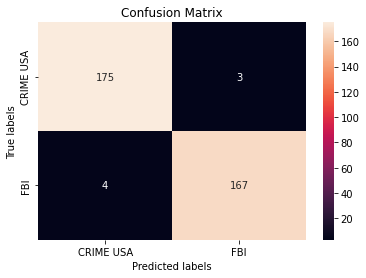

In [96]:
#set seed
np.random.seed(26)
#SVM MODEL WITH LINEAR KERNEL
#GETTING THE BEST COST MARGIN
svc_param_selection(TrainDF, TrainLabels,"linear")
#PREDICT THE TEST DATA
SVM_Model=SVC(kernel='linear', C=0.5, probability=True)
SVM_Model.fit(TrainDF, TrainLabels)

Preds_SVM1 = SVM_Model.predict(TestDF)
Pred_Proba_SVM1 = SVM_Model.predict_proba(TestDF)
SVM_matrix = confusion_matrix(TestLabels, Preds_SVM1)
print(metrics.classification_report(TestLabels, Preds_SVM1))

#VISUALIZE THE CONFUSION MATRIX
labels = ['CRIME USA', 'FBI']
ax1=plt.subplot()
sns.heatmap(confusion_matrix(TestLabels, Preds_SVM1), annot=True, fmt='g', ax=ax1)

#LABELS, TITLE AND TICKS
ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels')
ax1.set_title('Confusion Matrix')
ax1.xaxis.set_ticklabels(labels)
ax1.yaxis.set_ticklabels(labels)
plt.show()
plt.close()

From the SVM model with Linear Kernel for the Cost margin of 0.5, the classification report says that the accuracy of the model is 98%. The precision of the model is 98%, the recall is 98% and the F1 Score is 98%. The model is not overfitting as the precision and recall values are the same. The model is not underfitting because the accuracy of the model is greater than 50%. The model is not biased because the precision and recall are the same.


**POLYNOMIAL KERNEL with SVM**

Polynomial Kernel depicts the degree of similarity between vectors in the training set of data in a feature space over polynomials of the variables that were initially employed in the kernel.The polynomial kernel is a kernel function in machine learning that is commonly used with support vector machines (SVMs) and other kernelized models to represent the similarity of vectors (training samples) in a feature space over polynomials of the original variables and facilitate the learning of non-linear models.

To be more explicit, if the input kernel = "poly" is used with the svc() function, a support vector classifier can be fitted. By presenting the cost of a margin violation, we may give an approximate idea of the financial damage it causes. By calling the svc() function, we can adjust the support vector classifier to the value of the cost argument (denoted by the letter C). Since we are performing supervised machine learning (classification) on categorical data, we frequently use a confusion matrix to determine the count of accurate and inaccurate predictions for distinct classes; in this model, we set the cost margin to 0.5.


              precision    recall  f1-score   support

           0       1.00      0.30      0.46       178
           1       0.58      1.00      0.73       171

    accuracy                           0.64       349
   macro avg       0.79      0.65      0.60       349
weighted avg       0.79      0.64      0.59       349



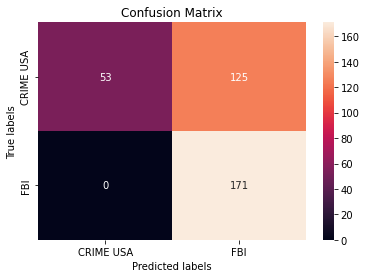

In [97]:
#set seed
np.random.seed(2)
#POLYNOMIAL KERNEL MODEL
#GETTING THE BEST COST MARGIN
svc_param_selection(TrainDF, TrainLabels,"poly")

#POLY KERNAL, C = 0.5
SVM_Model2=SVC(kernel='poly', C=0.5,probability=True)
SVM_Model2.fit(TrainDF, TrainLabels)

Preds_SVM2 = SVM_Model2.predict(TestDF)
Pred_Proba_SVM2 = SVM_Model2.predict_proba(TestDF)
SVM_matrix = confusion_matrix(TestLabels, Preds_SVM2)
print(metrics.classification_report(TestLabels, Preds_SVM2))

#VISCALIZE THE CONFUSION MATRIX
labels = ['CRIME USA', 'FBI']
ax1=plt.subplot()
sns.heatmap(confusion_matrix(TestLabels, Preds_SVM2), annot=True, fmt='g', ax=ax1)

#LABELS, TITLE AND TICKS
ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels')
ax1.set_title('Confusion Matrix')
ax1.xaxis.set_ticklabels(labels)
ax1.yaxis.set_ticklabels(labels)
plt.show()
plt.close()

From the SVM model with Polynomial Kernel for the Cost margin of 0.5, the classification report says that the accuracy of the model is 64%. The precision of the model is 79%, the recall is 65% and the F1 Score is 60%. In this model precision is greater than accuaracy which tells us that precoision is independent of accurary. The model is not underfitting because the accuracy of the model is greater than 50%. The model is not imbalanced because the number of data for each label is the same.

**SVM with RBF KERNELS**

RBF kernels are the most generalized kind of kernelization. They are also one of the most often used kernels because of their resemblance to the Gaussian distribution, which is one of the most common distributions. It is a kernel that can be used for a variety of applications and is utilized in circumstances in which there is no prior information about the data. Specifically, it is used in cases where there is no prior knowledge about the data.

To be more explicit, if the input kernel = "rbf" is used with the svc() function, a support vector classifier can be fitted. By presenting the cost of a margin violation, we may give an approximate idea of the financial damage it causes. By calling the svc() function, we can adjust the support vector classifier to the value of the cost argument (denoted by the letter C). Since we are performing supervised machine learning (classification) on categorical data, we frequently use a confusion matrix to determine the count of accurate and inaccurate predictions for distinct classes; in this model, we set the cost margin to 0.5.

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       178
           1       0.99      0.81      0.89       171

    accuracy                           0.91       349
   macro avg       0.92      0.90      0.90       349
weighted avg       0.92      0.91      0.90       349



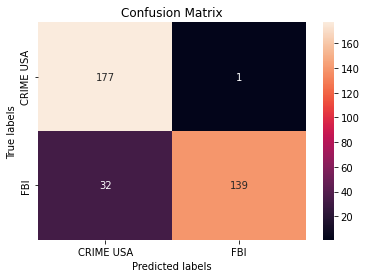

In [98]:
#set seed
np.random.seed(2)
#RBF MODEL
#GETTING THE BEST COST MARGIN
svc_param_selection(TrainDF, TrainLabels,"rbf")

# RBF Kernal - C = 0.5
SVM_Model3=SVC(kernel='rbf', C=0.5,probability=True)
SVM_Model3.fit(TrainDF, TrainLabels)

Preds_SVM3 = SVM_Model3.predict(TestDF)
Pred_Proba_SVM3 = SVM_Model3.predict_proba(TestDF)
SVM_matrix3 = confusion_matrix(TestLabels, Preds_SVM3)
print(metrics.classification_report(TestLabels, Preds_SVM3))

#VISUALIZE THE CONFUSION MATRIX
labels = ['CRIME USA', 'FBI']
ax1=plt.subplot()
sns.heatmap(confusion_matrix(TestLabels, Preds_SVM3), annot=True, fmt='g', ax=ax1)

#LABELS, TITLE AND TICKS
ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels')
ax1.set_title('Confusion Matrix')
ax1.xaxis.set_ticklabels(labels) 
ax1.yaxis.set_ticklabels(labels)
plt.show()
plt.close()

From the SVM model with RBF Kernel for the Cost margin of 0.5, the classification report says that the accuracy of the model is 91%. The precision of the model is 92%, the recall is 90% and the F1 Score is 90%. The model is not overfitting as the precision and recall values are the same. The model is not underfitting because the accuracy of the model is greater than 50%. The model is not biased because the precision and recall are the same. 

**CONCLUSION**

The SVM model was used to classify tweets that were generated from Twitter into the respective hashtag classes (FBI and USA CRIME) of other tweets. When it comes to determining the category, the models have an accuracy ranging from 64% to 98%, which is considered to be rather high. The model is able to make predictions about the tweets or to categorize them into different groups thanks to the collection of terms. The linear model are the most appropriate representations of these data since they account for 98% of the variance. 